<h2>Análise exploratória e criação de modelo de Machine Learning para mercado imobiliário</h2>
<h5>Esse código é parte do trabalho final desenvolvido para o curso de Data Science e Machine Learning da Tera. A ideia é explorar uma base de dados de mercado imobiliário para realizar a exploração e manipulação dos dados, bem como criar um modelo de Machine Learning a partir de um dos algorítmos previstos no curso. A base principal de dados utilizada nesse trabalho é o relatório de lançamentos imobiliários da Empresa Brasileira de Estudos de Patrimônio (EMBRAESP), contendo dados dos lançamentos imobiliários residenciais na Região Metropolitana de Sâo Paulo entre 1985-2013, a base foi disponibilizada pelo Centro de Estudos da Metrópole (CEM)</h5>

<h3>0.0 Importando as bibliotecas</h3>
<h5>Para mais informações sobre os pré-requisitos visualize o arquivo "requirements" que se encontra no repositório</h5>

In [1]:
#Evitando alguns avisos de erros que atrapalham a leitura do código
import warnings
warnings.filterwarnings("ignore")

#Bibliotecas de importação de dados
import basedosdados as bd

#Manipulação de dados
import pandas as pd
import numpy as np

#Visualização de dados
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

<h3>0.1 Definindo algumas funções do código</h3>
<h5>Essas são algumas funções que são definidas anteriormente porque são utilizadas recorrentemente no código ou são fruto de trabalhos anteriores</h5>

In [2]:
def plot_hist_variaveis(conjunto, dataframe, i=0):
    total_plots = len(conjunto)
    fig = plt.figure(figsize=(30,90))
    fig.subplots_adjust(hspace=0.8, wspace=0.3)

    for var in conjunto:
        ax = fig.add_subplot(total_plots, 2, i+1)

        sns.distplot(x=dataframe[var], ax=ax, color='#435058')
        ax.axvline(x=dataframe[var].mean(), linestyle='--', color='red')
        ax.set_title(var + '. Média = {}'.format(round(dataframe[var].mean(), 2)))
        ax.set_ylabel('')
        ax.set_xlabel('')
        i += 1

def plot_violin_variaveis(conjunto, dataframe,resposta, i=0):
    total_plots = len(conjunto)
    fig = plt.figure(figsize=(30,90))
    fig.subplots_adjust(hspace=0.2, wspace=0.3)

    for var in conjunto:
        ax = fig.add_subplot(total_plots, 2, i+1)

        sns.boxplot(x=dataframe[var], ax=ax, y=dataframe[resposta], color='#435058')
        ax.set_title(var)
        ax.set_ylabel('')
        ax.set_xlabel('')
        plt.xticks(rotation=90)
        #plt.show()
        i += 1

def otimiza_dataframe (dataframe):
    counter_num = 0
    counter_cat = 0
    for col in dataframe.columns:
      if dataframe[col].dtype == 'int64':
          if dataframe[col].max() < 2**7 and dataframe[col].min() > -(2**7):
            dataframe[col] = dataframe[col].astype(np.int8) 
            counter_num += 1 
          elif dataframe[col].max() < 2**15 and dataframe[col].min() > -(2**15):
            dataframe[col] = dataframe[col].astype(np.int16)  
            counter_num += 1 
          elif dataframe[col].max() < 2**31 and dataframe[col].min() > -(2**31):
            dataframe[col] = dataframe[col].astype(np.int32)  
            counter_num += 1 
          elif dataframe[col].max() < 2**63 and dataframe[col].min() > -(2**63):
            dataframe[col] = dataframe[col].astype(np.int64) 
            counter_num += 1    

      elif dataframe[col].dtype == 'float64': 
          if dataframe[col].max() < 2**31 and dataframe[col].min() > -(2**31):
            dataframe[col] = dataframe[col].astype(np.float32)
            counter_num += 1 

      elif dataframe[col].dtype == 'object':
        dataframe[col] = dataframe[col].astype('category')
        counter_cat += 1
    print('Foram otimizadas {} variáveis numéricas e  {} variáveis categóricas'.format(counter_num, counter_cat))



    

<h3>1. Lendo e ajustando as bases</h3>
<h5>A base da EMBRAESP contém, sozinha, uma série de informações úteis sobre o mercado imobiliário residencial na cidade mas achou-se proveitosa a conexão com algumas bases do Censo Demográfico de 2010, a fim de elaborar uma compreensão melhor sobre o quadro temático de onde os edifícios lançados se encontram. Todas as bases do Censo foram obtidas diretamente do diretório do Base de Dados</h5>

In [3]:
#Obtendo o dataframe do Censo Demográfico (Básico) a partir da Base dos Dados
df_censo_basico = bd.read_table(dataset_id='br_ibge_censo_demografico',
table_id='setor_censitario_basico_2010', billing_project_id="229299106527")

Downloading: 100%|██████████| 310120/310120 [01:27<00:00, 3528.48rows/s]


In [4]:
#Selecionando no dataframe do Censo demográfico apenas os dados de São Paulo. SP1 = São Paulo/SP, SP2 = Demais regiões do Estado.
estado = ['SP1', 'SP2']
df_censo_basico = df_censo_basico[df_censo_basico['sigla_uf'].isin(estado)]

In [5]:
#Lendo os dados da EMBRAESP
path = "LANRES_85_13_RMSP_CEM.csv"
df = pd.read_csv(path, delimiter=';', decimal=',')

<h3>1.1 Pré tratamento das bases</h3>
<h5>Alguns pré-tratamentos das duas bases, envolvendo a modificação de tipos das colunas (para facilitar a intersecção posterior entre elas) e a remoção de colunas que não são consideradas úteis para a análise, além do preenchimento de valores nulos</h5>

In [6]:
#Compatibilizando os tipos da coluna que vai servir de join entre os dataframes e renomeando algumas variáveis para facilitar a interpretação
df_censo_basico['id_setor_censitario'] = df_censo_basico['id_setor_censitario'].astype('int64')
df_censo_basico = df_censo_basico.rename({'v001':'Domicílios_Setor', 'v003':'Média_Moradores_por_domicilio_setor', 'v005':'Média_Renda_Responsaveis_Setor'}, axis=1)

In [7]:
#Removendo colunas categóricas com dados muito fragmentados e que não oferecem boa leitura pela alto grau de cardinalidade 
df = df.drop(['NOME_EMP','CEP','SETOR', 'QUADRA', 'LOTE', 'COD_EMP', 'ENDERECOCO', 'LOGRADOURO', 'TIT_VIA', 'NUM','CEP_4DIG', 'ENGENHEIRO', 'ARQUITETO', 'HOTELARIA', 'INCOPORADO'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16935 entries, 0 to 16934
Data columns (total 70 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          16935 non-null  int64  
 1   TIPO_EMP    16935 non-null  object 
 2   MES_LAN     16935 non-null  object 
 3   ANO_LAN     16935 non-null  int64  
 4   DATA_ENT    16935 non-null  object 
 5   DIST        13234 non-null  object 
 6   SUBPREF     13234 non-null  object 
 7   MUNICIPIO   16935 non-null  object 
 8   TIPO_VIA    16929 non-null  object 
 9   ZONA        16935 non-null  object 
 10  DORM_UNID   16935 non-null  int64  
 11  BANH_UNID   16935 non-null  int64  
 12  GAR_UNID    16935 non-null  int64  
 13  ELEV        16935 non-null  int64  
 14  COB         16935 non-null  int64  
 15  BLOCOS      16935 non-null  int64  
 16  UNIDAND     16935 non-null  int64  
 17  ANDARES     16935 non-null  int64  
 18  AR_UT_UNID  16935 non-null  float64
 19  AR_TT_UNID  16935 non-nul

In [8]:
#Removendo colunas de incorporadora, vendedoras e construtoras secundárias no processo dos edifícios. Na maior parte das linhas só há dados para os agentes primários e os agentes secundários tem muitos nulos
remover = []
for col in df.columns:
    for nome in ['INCORPOR_', 'VENDEDOR', 'CONSTRUT_']:
        remover.append(col) if nome in col and col != ('INCORPOR_A' or 'CONSTRUT_A') else None

#por algum motivo uma variável a mais entrou na lista de remoção, vou remover na mão e depois checo o porquê disso
remover.remove('CONSTRUT_A')
df = df.drop(remover, axis=1)

In [9]:
#As variáveis de distrito e subprefeitura só fazem menção aos locais dentro da cidade de São Paulo, então coloquei os valores nulos como "Fora de São Paulo", apenas para facilitar a manipulação posterior
df[['DIST', 'SUBPREF']] = df[['DIST', 'SUBPREF']].fillna('FORA-SP')

#Essas colunas possuiam poucos valores nulos, que foram preenchidos com a mediana de todo o conjunto de dados em cada coluna
for col in ['RENRESP91', 'PCMEDAU91', 'PCMEDAU00','PCMEDAU10']:
    df[col] = df[col].fillna(df[col].median())

#Colunas numéricas que na verdade são categóricas
for col in ['COOPERATIV', 'HOTEL', 'FLAT', 'EXFLAT']:
    df[col] = df[col].astype(dtype='category')

<h3>1.2 Junção das bases</h3>
<h5>A conexão das bases é realizada a partir do setor censitário, logo, as informações captadas do Censo dizem respeito a todo o setor censitário ao qual o empreendimento está inserido, um setor censitário pode conter (e normalmente contém) mais de um empreendimento. O Censo do IBGE possui uma infinidade de variáveis e foram selecionadas apenas algumas que dão uma visão geral sobre o setor.</h5>

In [10]:
#Juntando a base da EMBRAESP e a(s) base(s) do Censo a partir dos setores censitários
df = df.join(df_censo_basico[['id_setor_censitario','Domicílios_Setor','Média_Moradores_por_domicilio_setor','Média_Renda_Responsaveis_Setor']].set_index('id_setor_censitario'), on='SC_2010', how='left')

In [11]:
df.head()

,ID,TIPO_EMP,MES_LAN,ANO_LAN,DATA_ENT,DIST,SUBPREF,MUNICIPIO,TIPO_VIA,ZONA,...,SC_2010,RENRESP91,RENRESP00,RENRESP10,PCMEDAU91,PCMEDAU00,PCMEDAU10,Domicílios_Setor,Média_Moradores_por_domicilio_setor,Média_Renda_Responsaveis_Setor
0,9037,HORIZ,15-JUL-2004,2004,15-JUL-2004,FORA-SP,FORA-SP,COTIA,Rua,R,...,351300910000022,112291.99,570.95,954.75,7503.537882,6859.178571,4139.39,248.0,3.46,920.34
1,16908,VERTIC,15-DEC-2013,2013,15-APR-2016,FORA-SP,FORA-SP,COTIA,Estr,R,...,351300910000026,112291.99,570.95,954.75,7503.537882,6859.178571,2470.97,218.0,3.79,759.29
2,16565,HORIZ,15-SEP-2013,2013,15-AUG-2015,FORA-SP,FORA-SP,COTIA,Estr,R,...,351300910000009,112291.99,570.95,954.75,7503.537882,6859.178571,4139.39,501.0,3.50,883.63
3,15812,HORIZ,15-DEC-2012,2012,15-MAR-2015,FORA-SP,FORA-SP,COTIA,Rua,R,...,351300910000031,112291.99,570.95,954.75,7503.537882,6859.178571,2566.94,176.0,3.48,706.65
4,15813,HORIZ,15-DEC-2012,2012,15-MAR-2015,FORA-SP,FORA-SP,COTIA,Rua,R,...,351300910000031,112291.99,570.95,954.75,7503.537882,6859.178571,2566.94,176.0,3.48,706.65


In [12]:
#Os dados das colunas são pesados e a otimização dos dataframes leva em consideração o tamanho dos números em cada coluna para converter a um dtype adequado, visando diminuir o peso.
otimiza_dataframe(df)

Foram otimizadas 41 variáveis numéricas e  14 variáveis categóricas


<h3>2. Definição das variáveis e análises visuais</h3>

<h5>São definidas as variáveis resposta (que será utilizada posteriormente no modelo de Machine Learning), bem como as variáveis numéricas e categóricas. A definição dessas variáveis ajuda na visualização dos dados e na execução dos pipelines</h5>

In [13]:
#A variável resposta é o Preço do M² da unidade a partir do valor atualizado de 2013. A divisão entre varia´veis int e float é apenas para possíveis questões de performance
v_resposta = "PC_M2_AT_U"
v_numericos = df.select_dtypes(include=["int8", "int16", "int32", "int64", "float"]).columns.to_list()
v_int = df.select_dtypes(include=["int8", "int16", "int32", "int64"]).columns.to_list()
v_float = df.select_dtypes(include="float").columns.to_list()

[v.remove(v_resposta) for v in [v_numericos]]
[v.remove('ID') for v in [v_numericos]]

v_categoricos = ['TIPO_EMP', 'DIST', 'SUBPREF', 'MUNICIPIO', 'TIPO_VIA', 'ZONA', 'SIST_FINAN', 'AGENTE']
#df.select_dtypes(include="category").columns.to_list()
v_datas = ['MES_LAN', 'DATA_ENT']
#v_categoricos.remove('MES_LAN') 
#v_categoricos.remove('DATA_ENT') 

In [14]:
#Recortando o ambiente de análise, selecionando apenas empreendimentos dentro da cidade de São Paulo
df_sp = df.query("MUNICIPIO == 'SAO PAULO'")

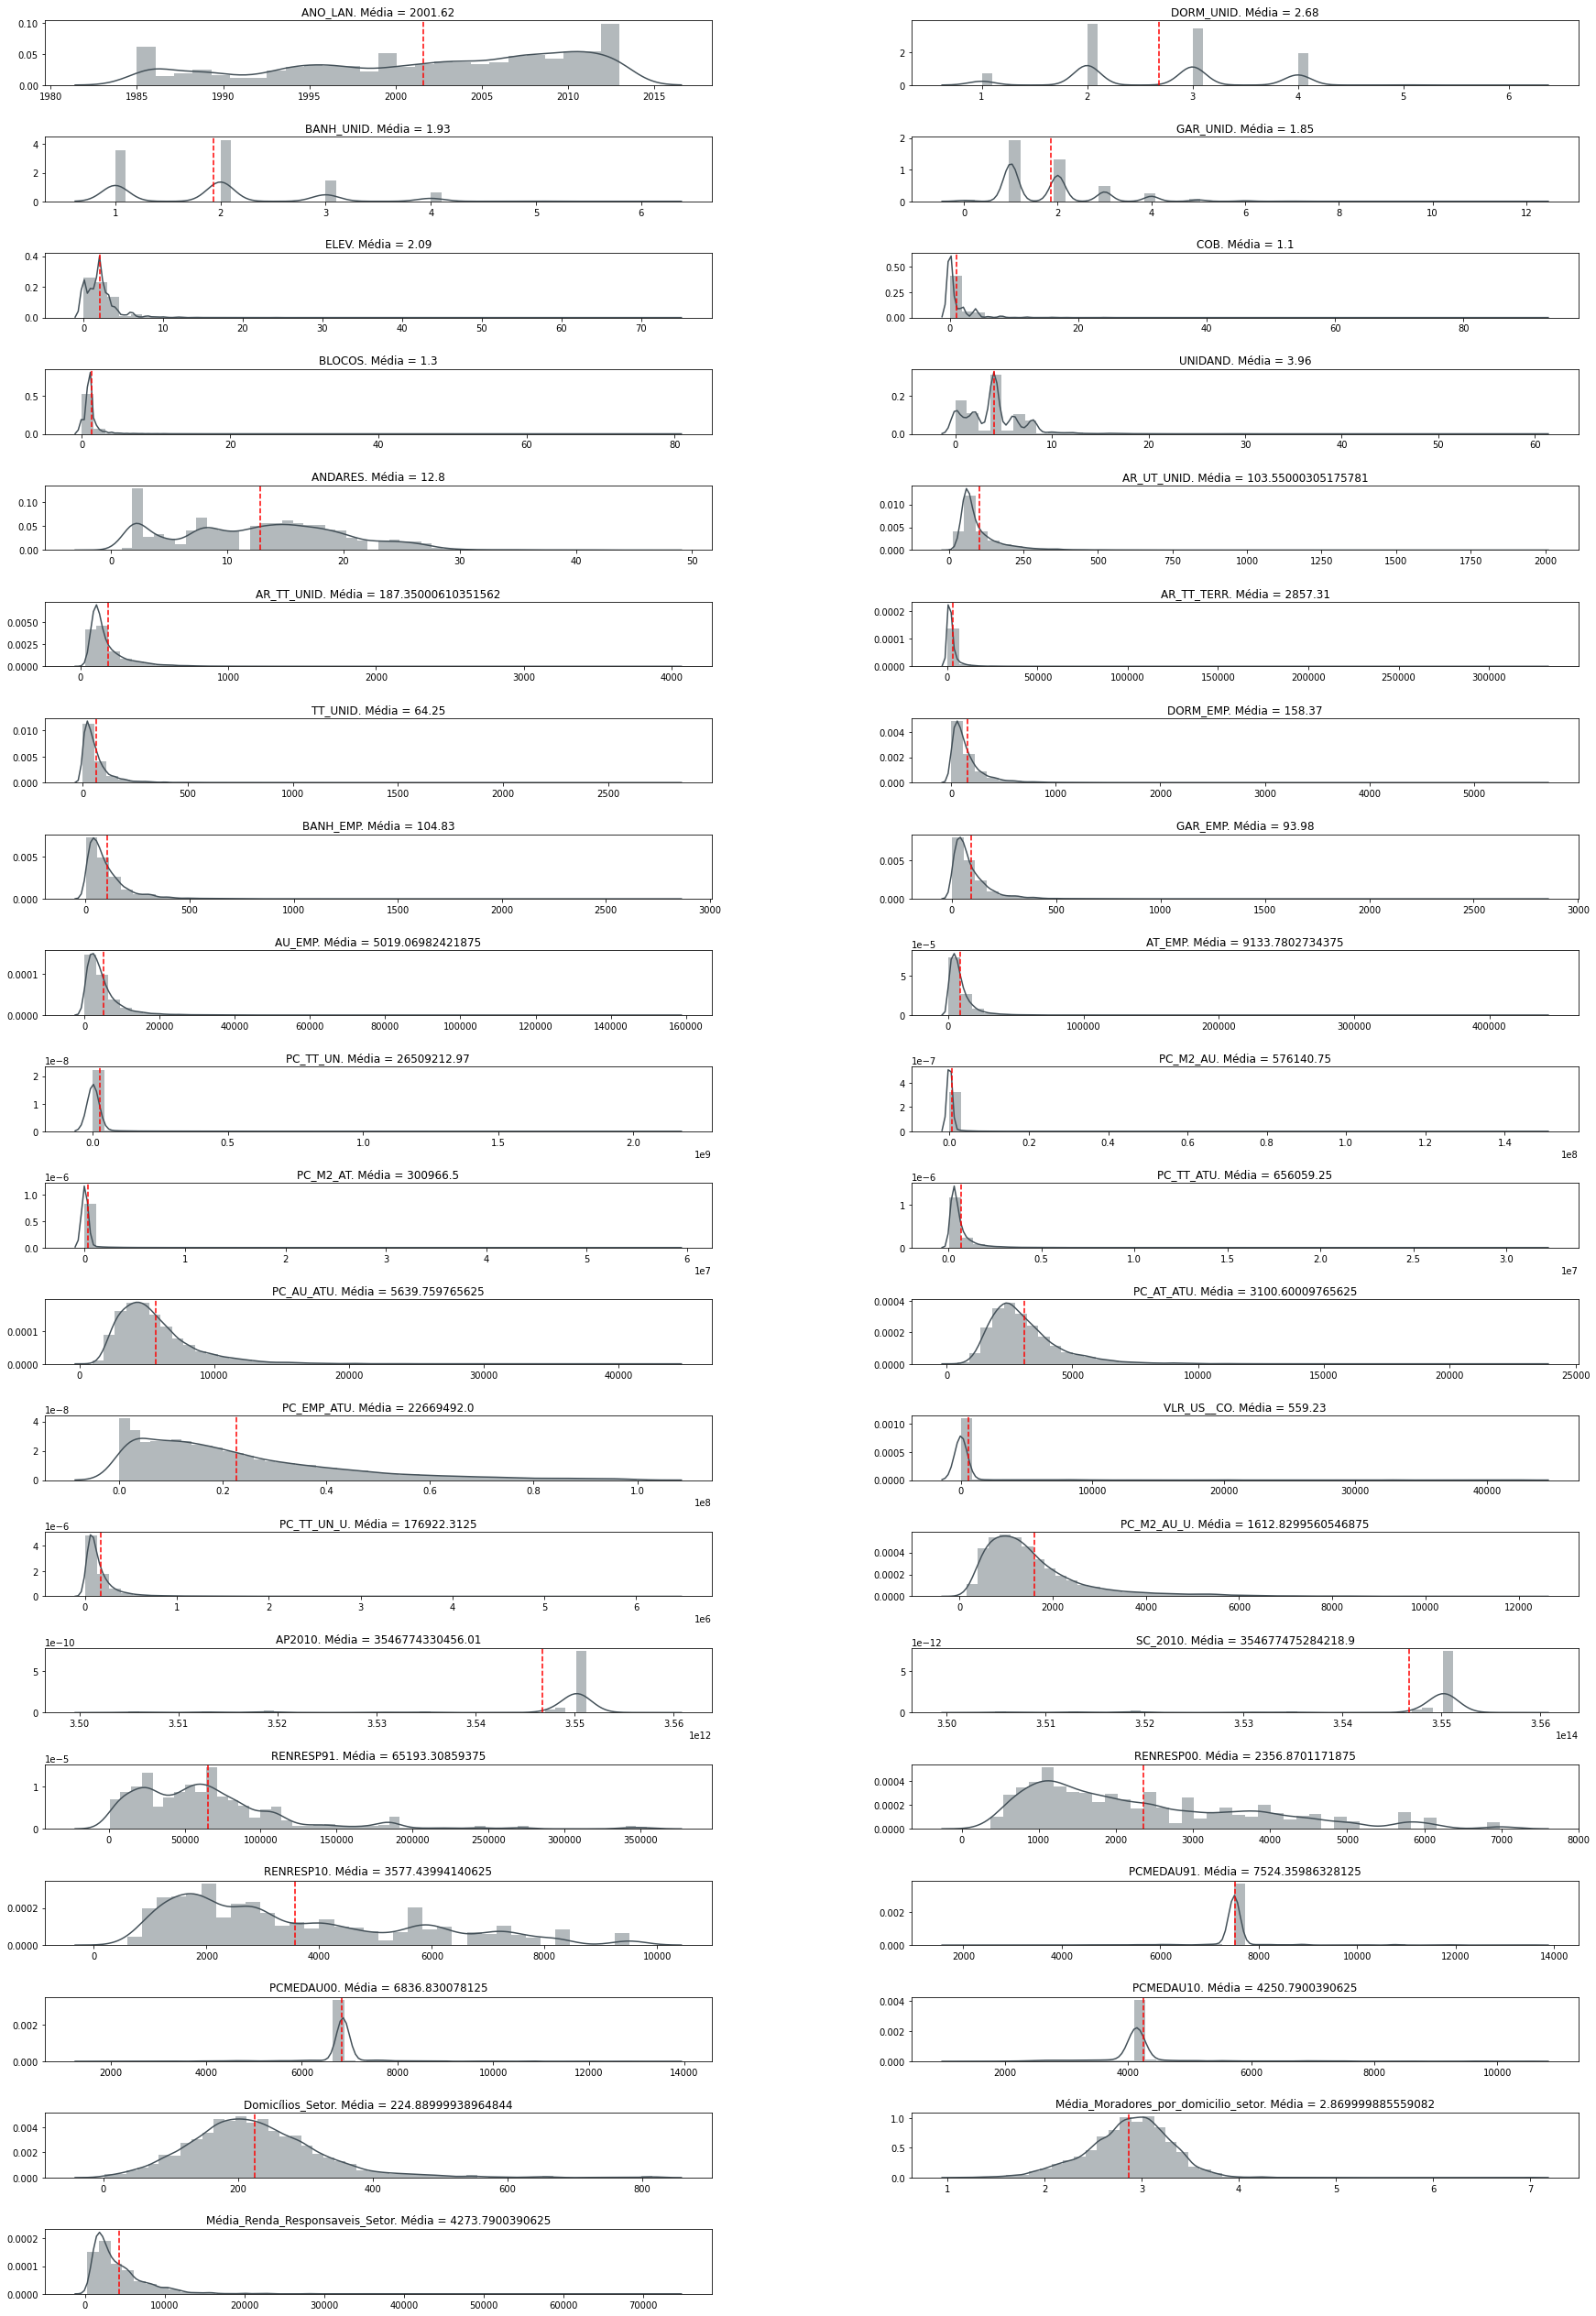

In [15]:
plot_hist_variaveis(v_numericos, df)

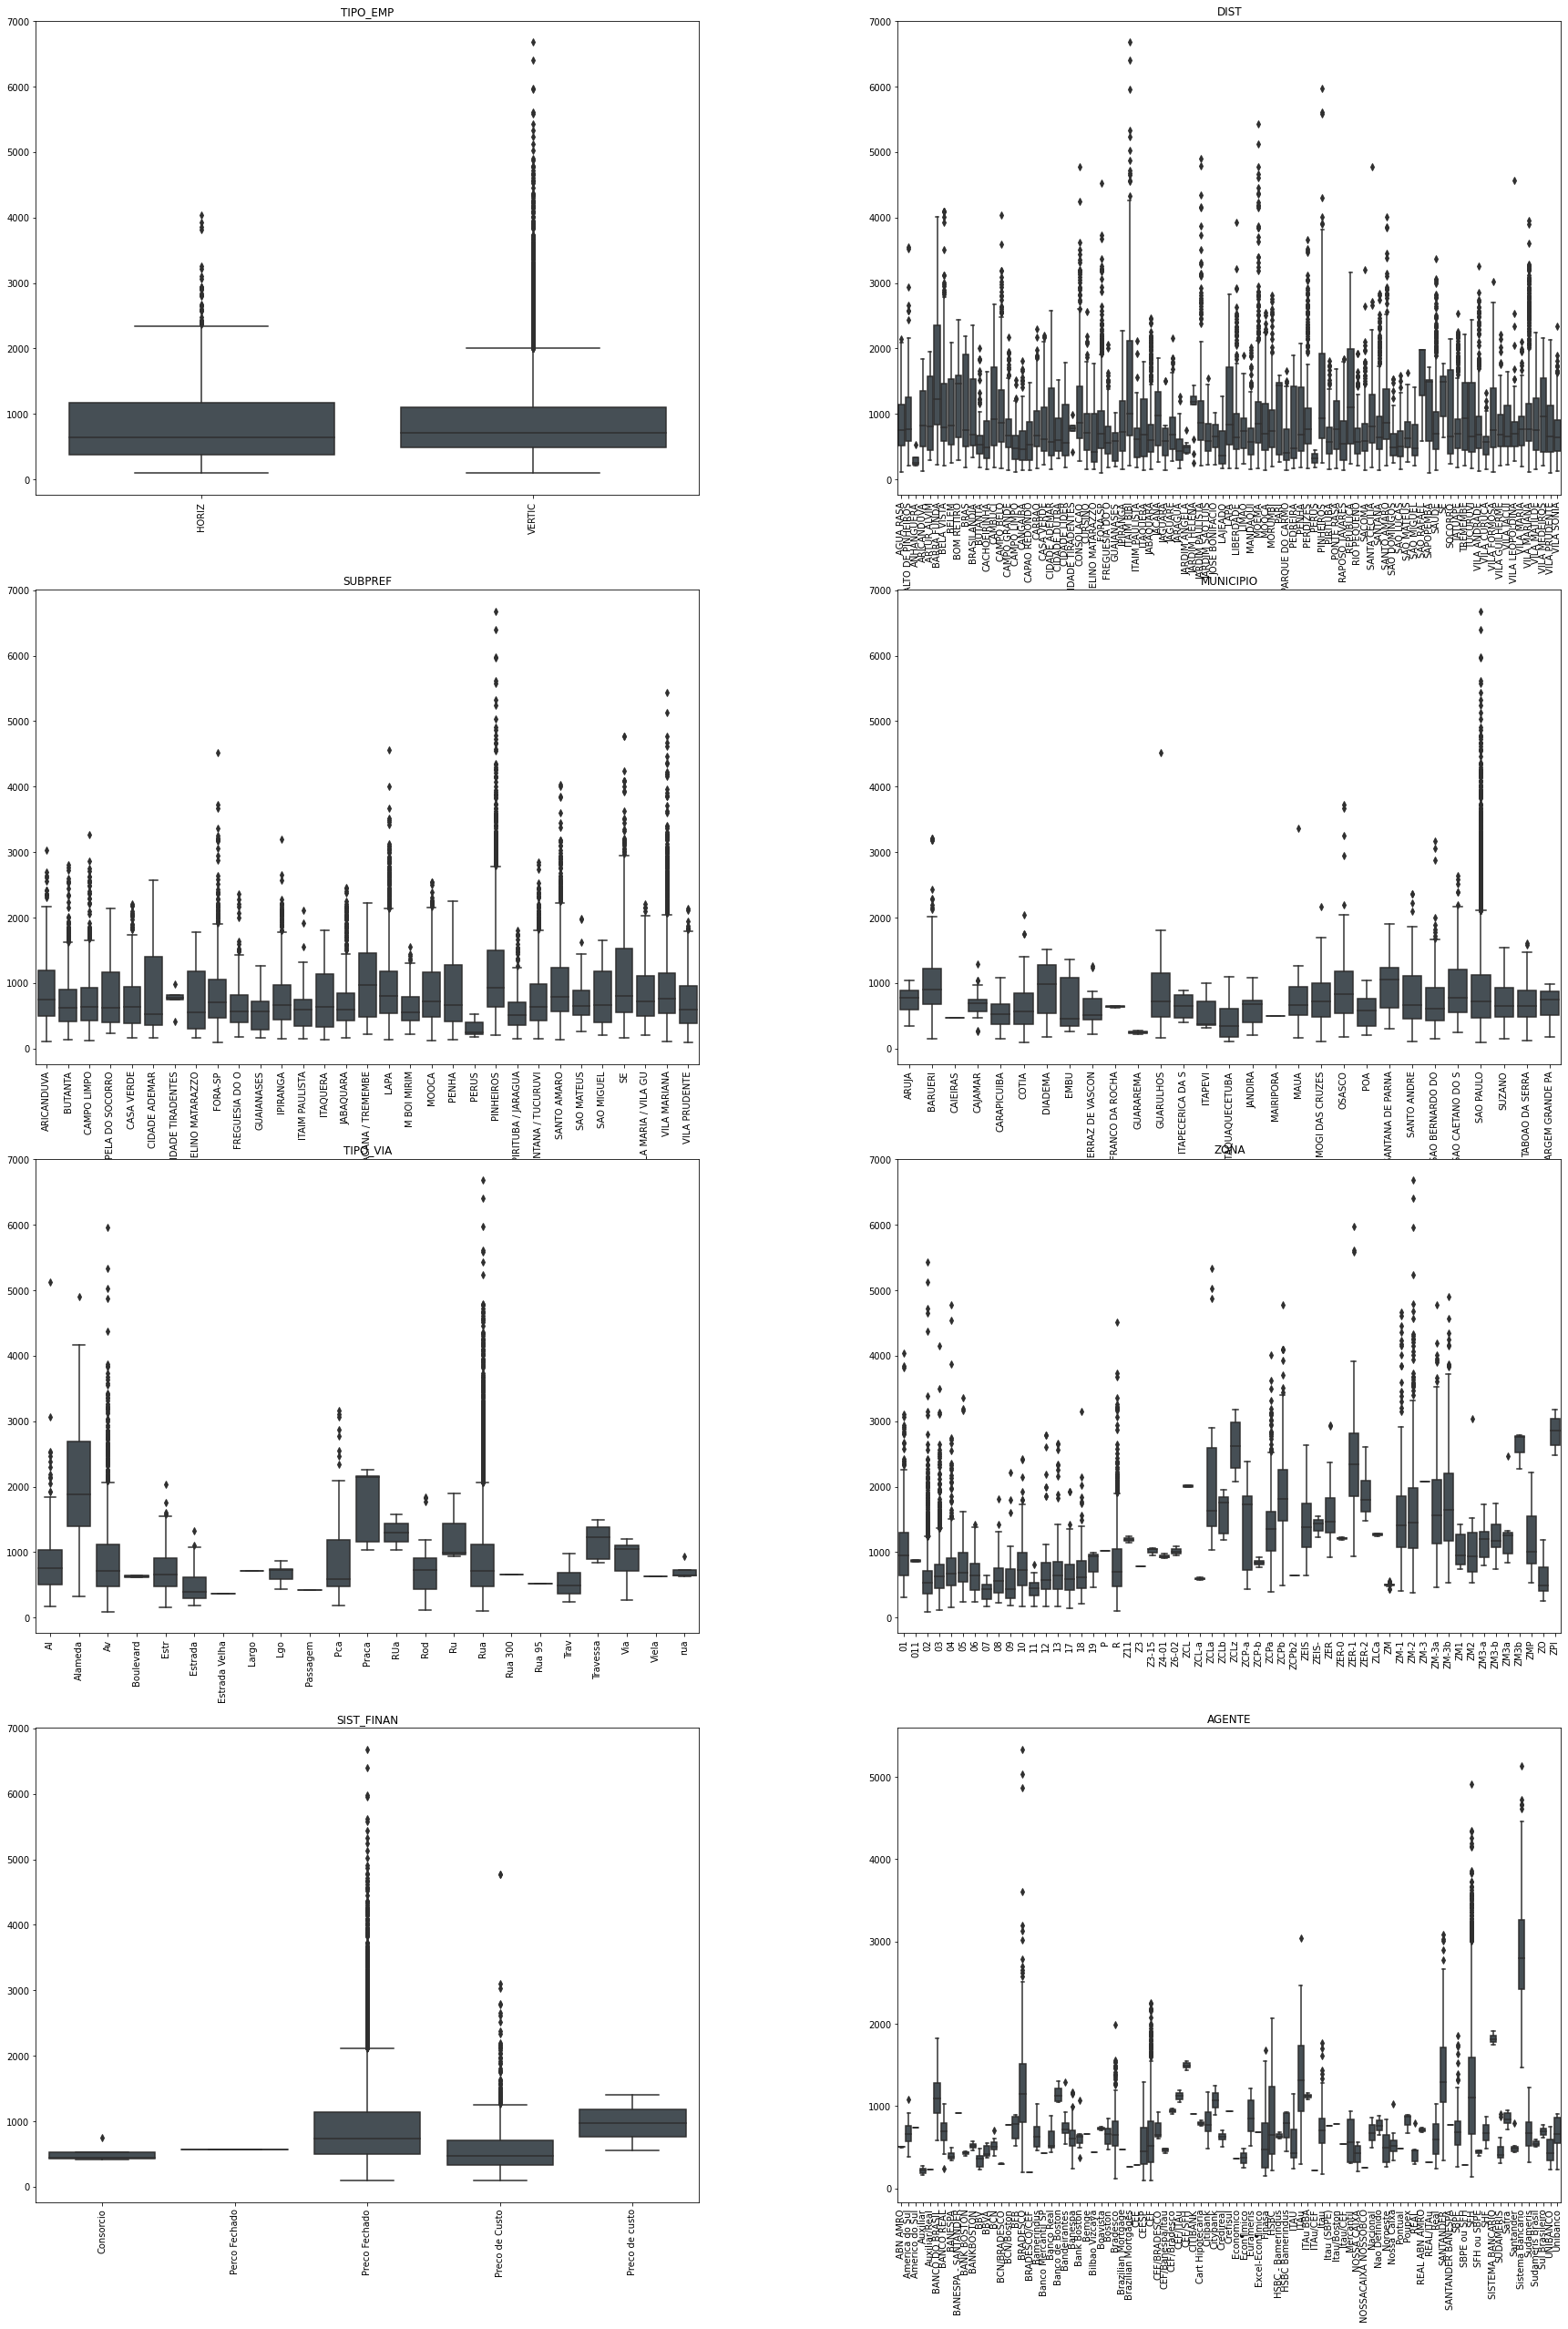

In [16]:
plot_violin_variaveis(dataframe=df, conjunto=v_categoricos, resposta=v_resposta)

In [17]:
for col in df[v_numericos].columns:
    limite = df[col].quantile(0.95)
    df[col] = df[col].where(df[col] < limite, limite)

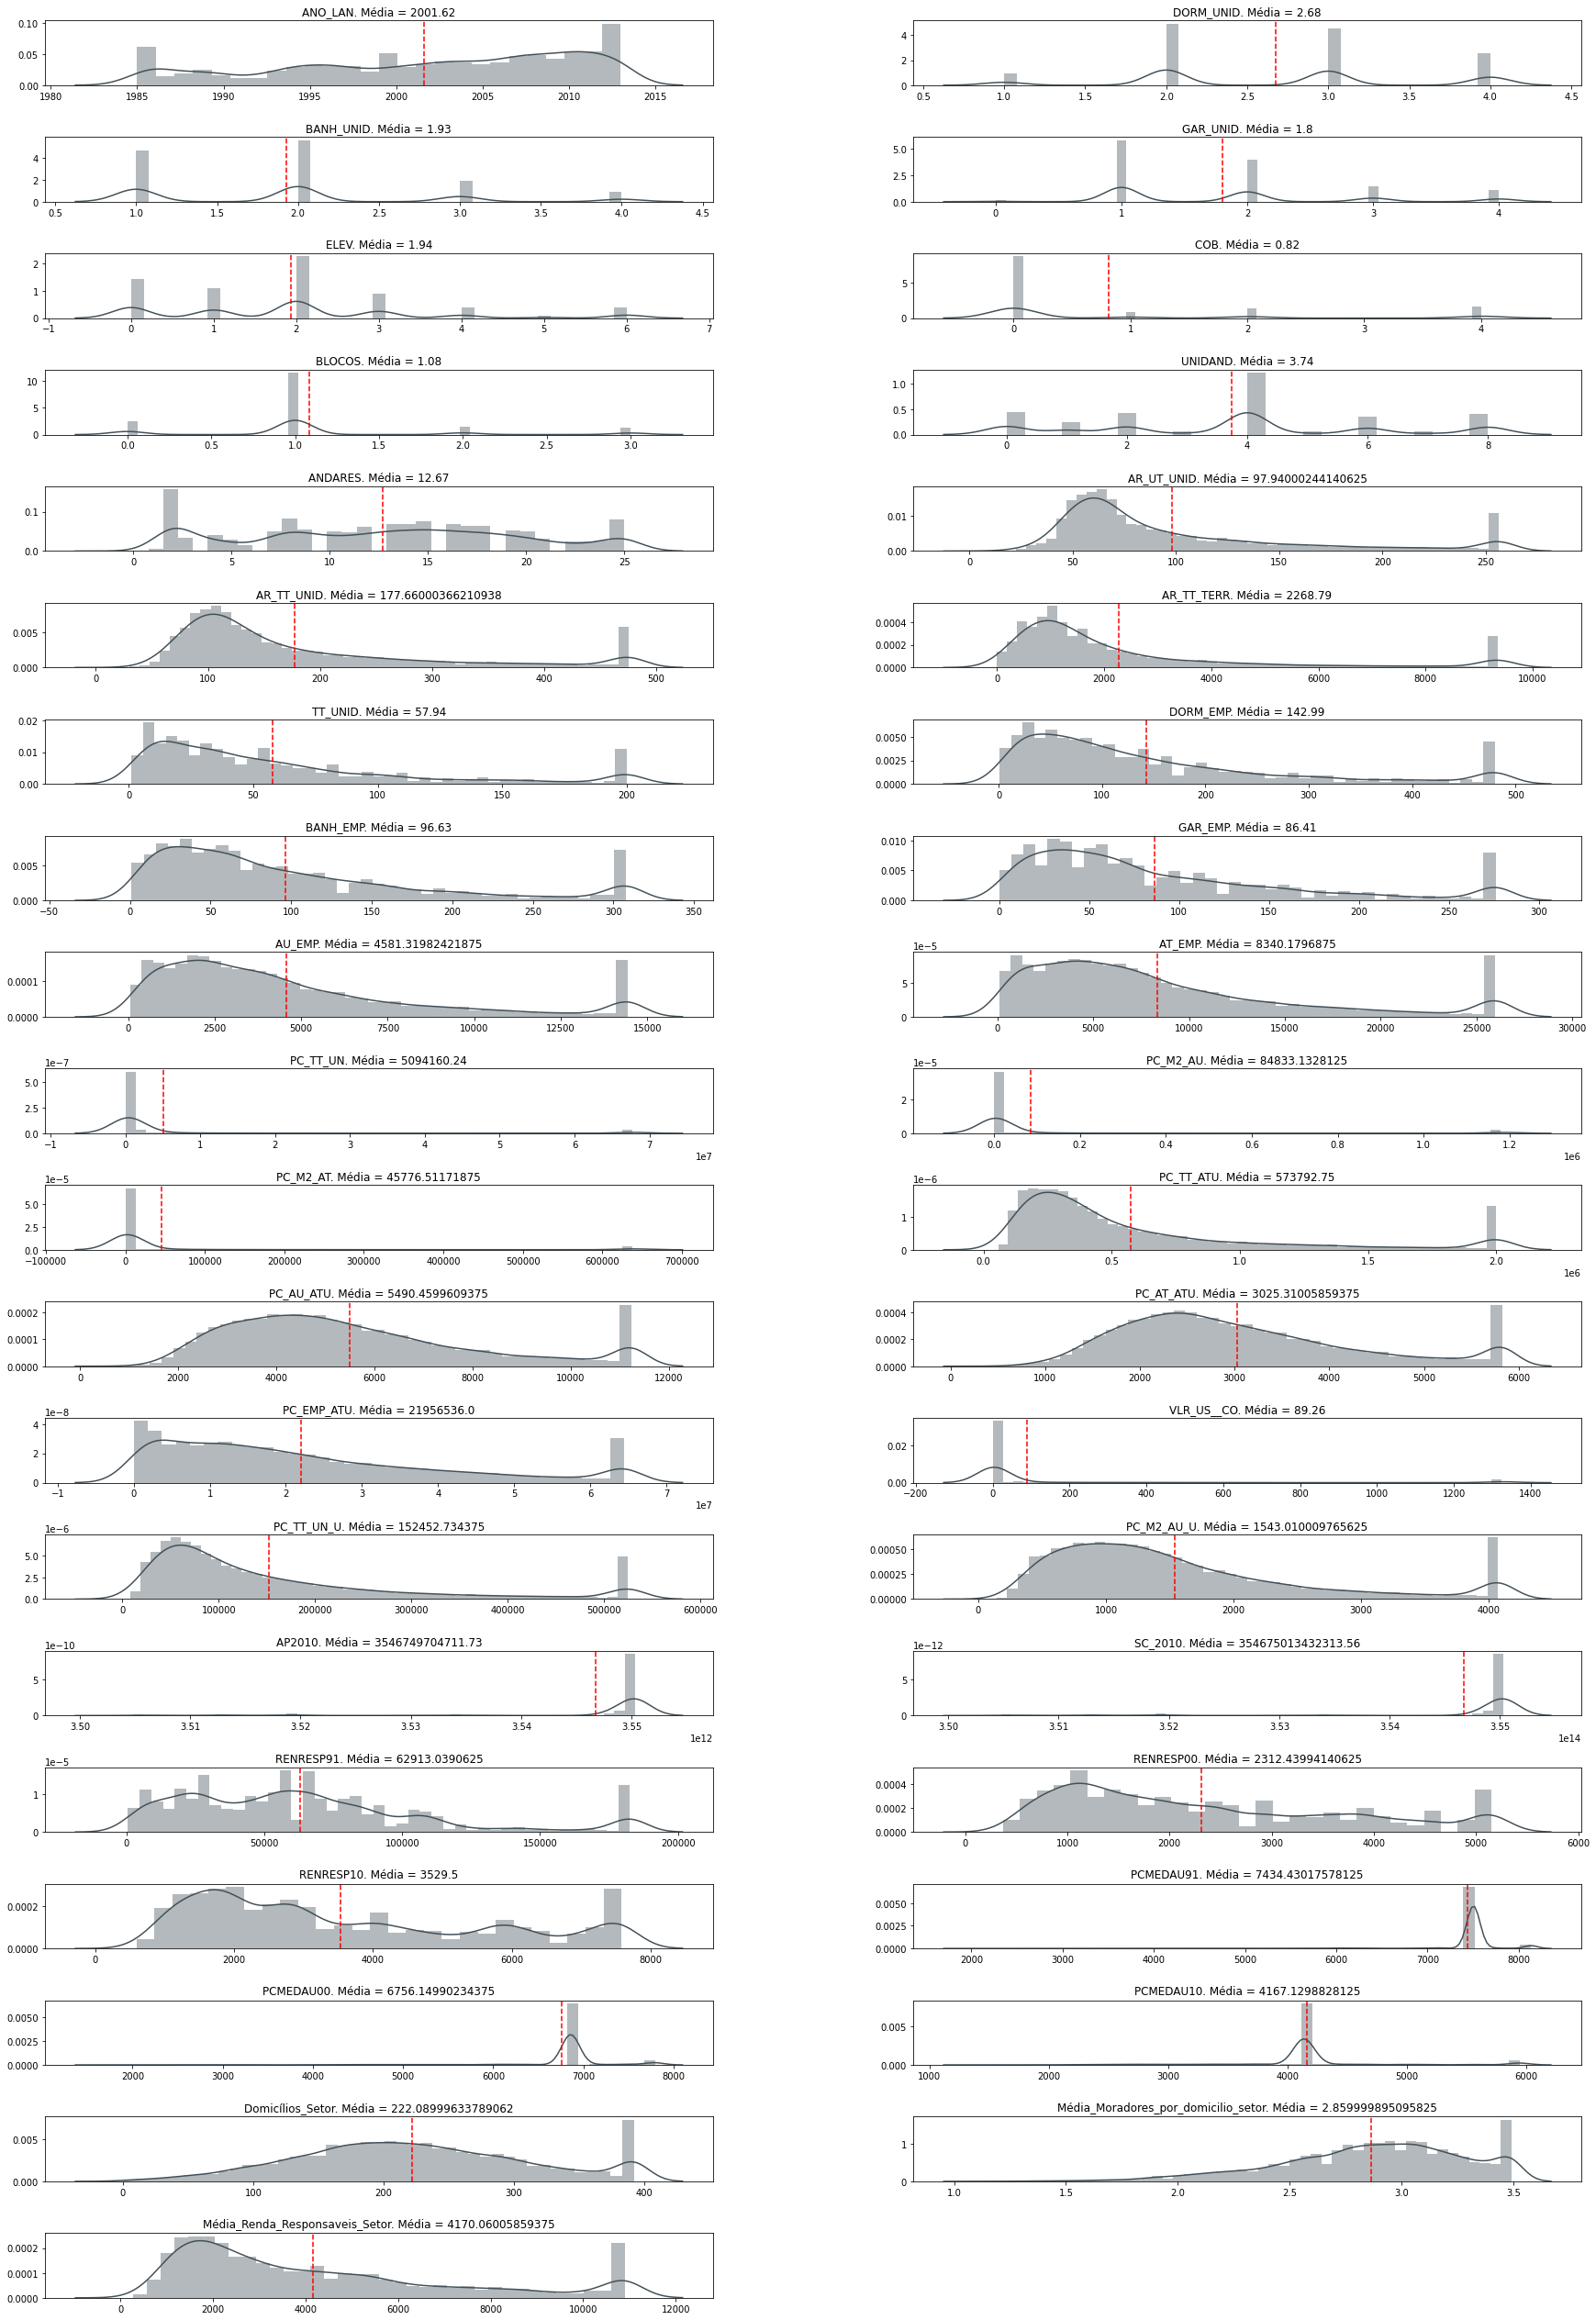

In [18]:
plot_hist_variaveis(v_numericos, df)

In [19]:
df[v_numericos].describe()

,ANO_LAN,DORM_UNID,BANH_UNID,GAR_UNID,ELEV,COB,BLOCOS,UNIDAND,ANDARES,AR_UT_UNID,...,SC_2010,RENRESP91,RENRESP00,RENRESP10,PCMEDAU91,PCMEDAU00,PCMEDAU10,Domicílios_Setor,Média_Moradores_por_domicilio_setor,Média_Renda_Responsaveis_Setor
count,16935.000000,16935.000000,16935.000000,16935.000000,16935.000000,16935.000000,16935.000000,16935.000000,16935.000000,16935.000000,...,1.693500e+04,16935.000000,16935.000000,16935.000000,16935.000000,16935.000000,16935.000000,16935.000000,16935.000000,16935.000000
mean,2001.621081,2.675465,1.929200,1.804901,1.938057,0.816120,1.083141,3.744553,12.674579,97.939369,...,3.546750e+14,62913.042969,2312.442627,3529.498047,7434.431641,6756.154297,4167.125977,222.085175,2.863857,4170.061035
std,8.376523,0.873354,0.878335,0.967568,1.580896,1.397905,0.725733,2.436496,6.915234,58.990685,...,1.010332e+12,44620.757812,1357.578979,2056.986572,504.187378,700.713867,616.545593,87.269943,0.412200,2919.977539
min,1985.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.720000,...,3.503901e+14,506.920013,370.339996,594.909973,1912.410034,1665.670044,1383.349976,1.000000,1.130000,277.269989
25%,1995.000000,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,8.000000,57.680000,...,3.550308e+14,27619.460938,1172.544983,1794.420044,7503.538086,6859.178711,4139.390137,162.000000,2.610000,1851.719971
50%,2003.000000,3.000000,2.000000,2.000000,2.000000,0.000000,1.000000,4.000000,13.000000,74.000000,...,3.550308e+14,56253.351562,1950.030029,2912.239990,7503.538086,6859.178711,4139.390137,216.000000,2.910000,3229.560059
75%,2009.000000,3.000000,2.000000,2.000000,3.000000,1.000000,1.000000,6.000000,18.000000,120.000000,...,3.550309e+14,83061.109375,3316.439941,5240.640137,7503.538086,6859.178711,4139.390137,281.000000,3.160000,5651.910156
max,2013.000000,4.000000,4.000000,4.000000,6.000000,4.000000,3.000000,8.000000,25.000000,256.335999,...,3.550309e+14,182593.859375,5152.680176,7578.899902,8137.380371,7799.950684,5945.379883,391.799988,3.490000,10897.959961


In [20]:
df_zero = df.loc[df['PC_TT_UN'] == 0]
df_zero.shape #118 colunas com preço da unidade igual a 0

(118, 59)

In [22]:
df['PC_TT_UN'].replace(0,df['PC_TT_UN'].mean(axis=0),inplace=True)
df['PC_TT_UN'].describe()

count    1.693500e+04
mean     5.129655e+06
std      1.571667e+07
min      2.460000e+04
25%      1.247115e+05
50%      2.730000e+05
75%      7.650250e+05
max      6.771115e+07
Name: PC_TT_UN, dtype: float64

In [23]:
v_precos = ['PC_TT_UN', 'PC_M2_AU', 'PC_M2_AT', 'VLR_US__CO', 'PCMEDAU91', 'PCMEDAU00', 'PCMEDAU10']

for col in v_precos:
    #df[col] = df[col].where(df[col] == 0, 0.0001)
    df[col+'_log'] = np.log(df[col])
    v_numericos.append(col+'_log')


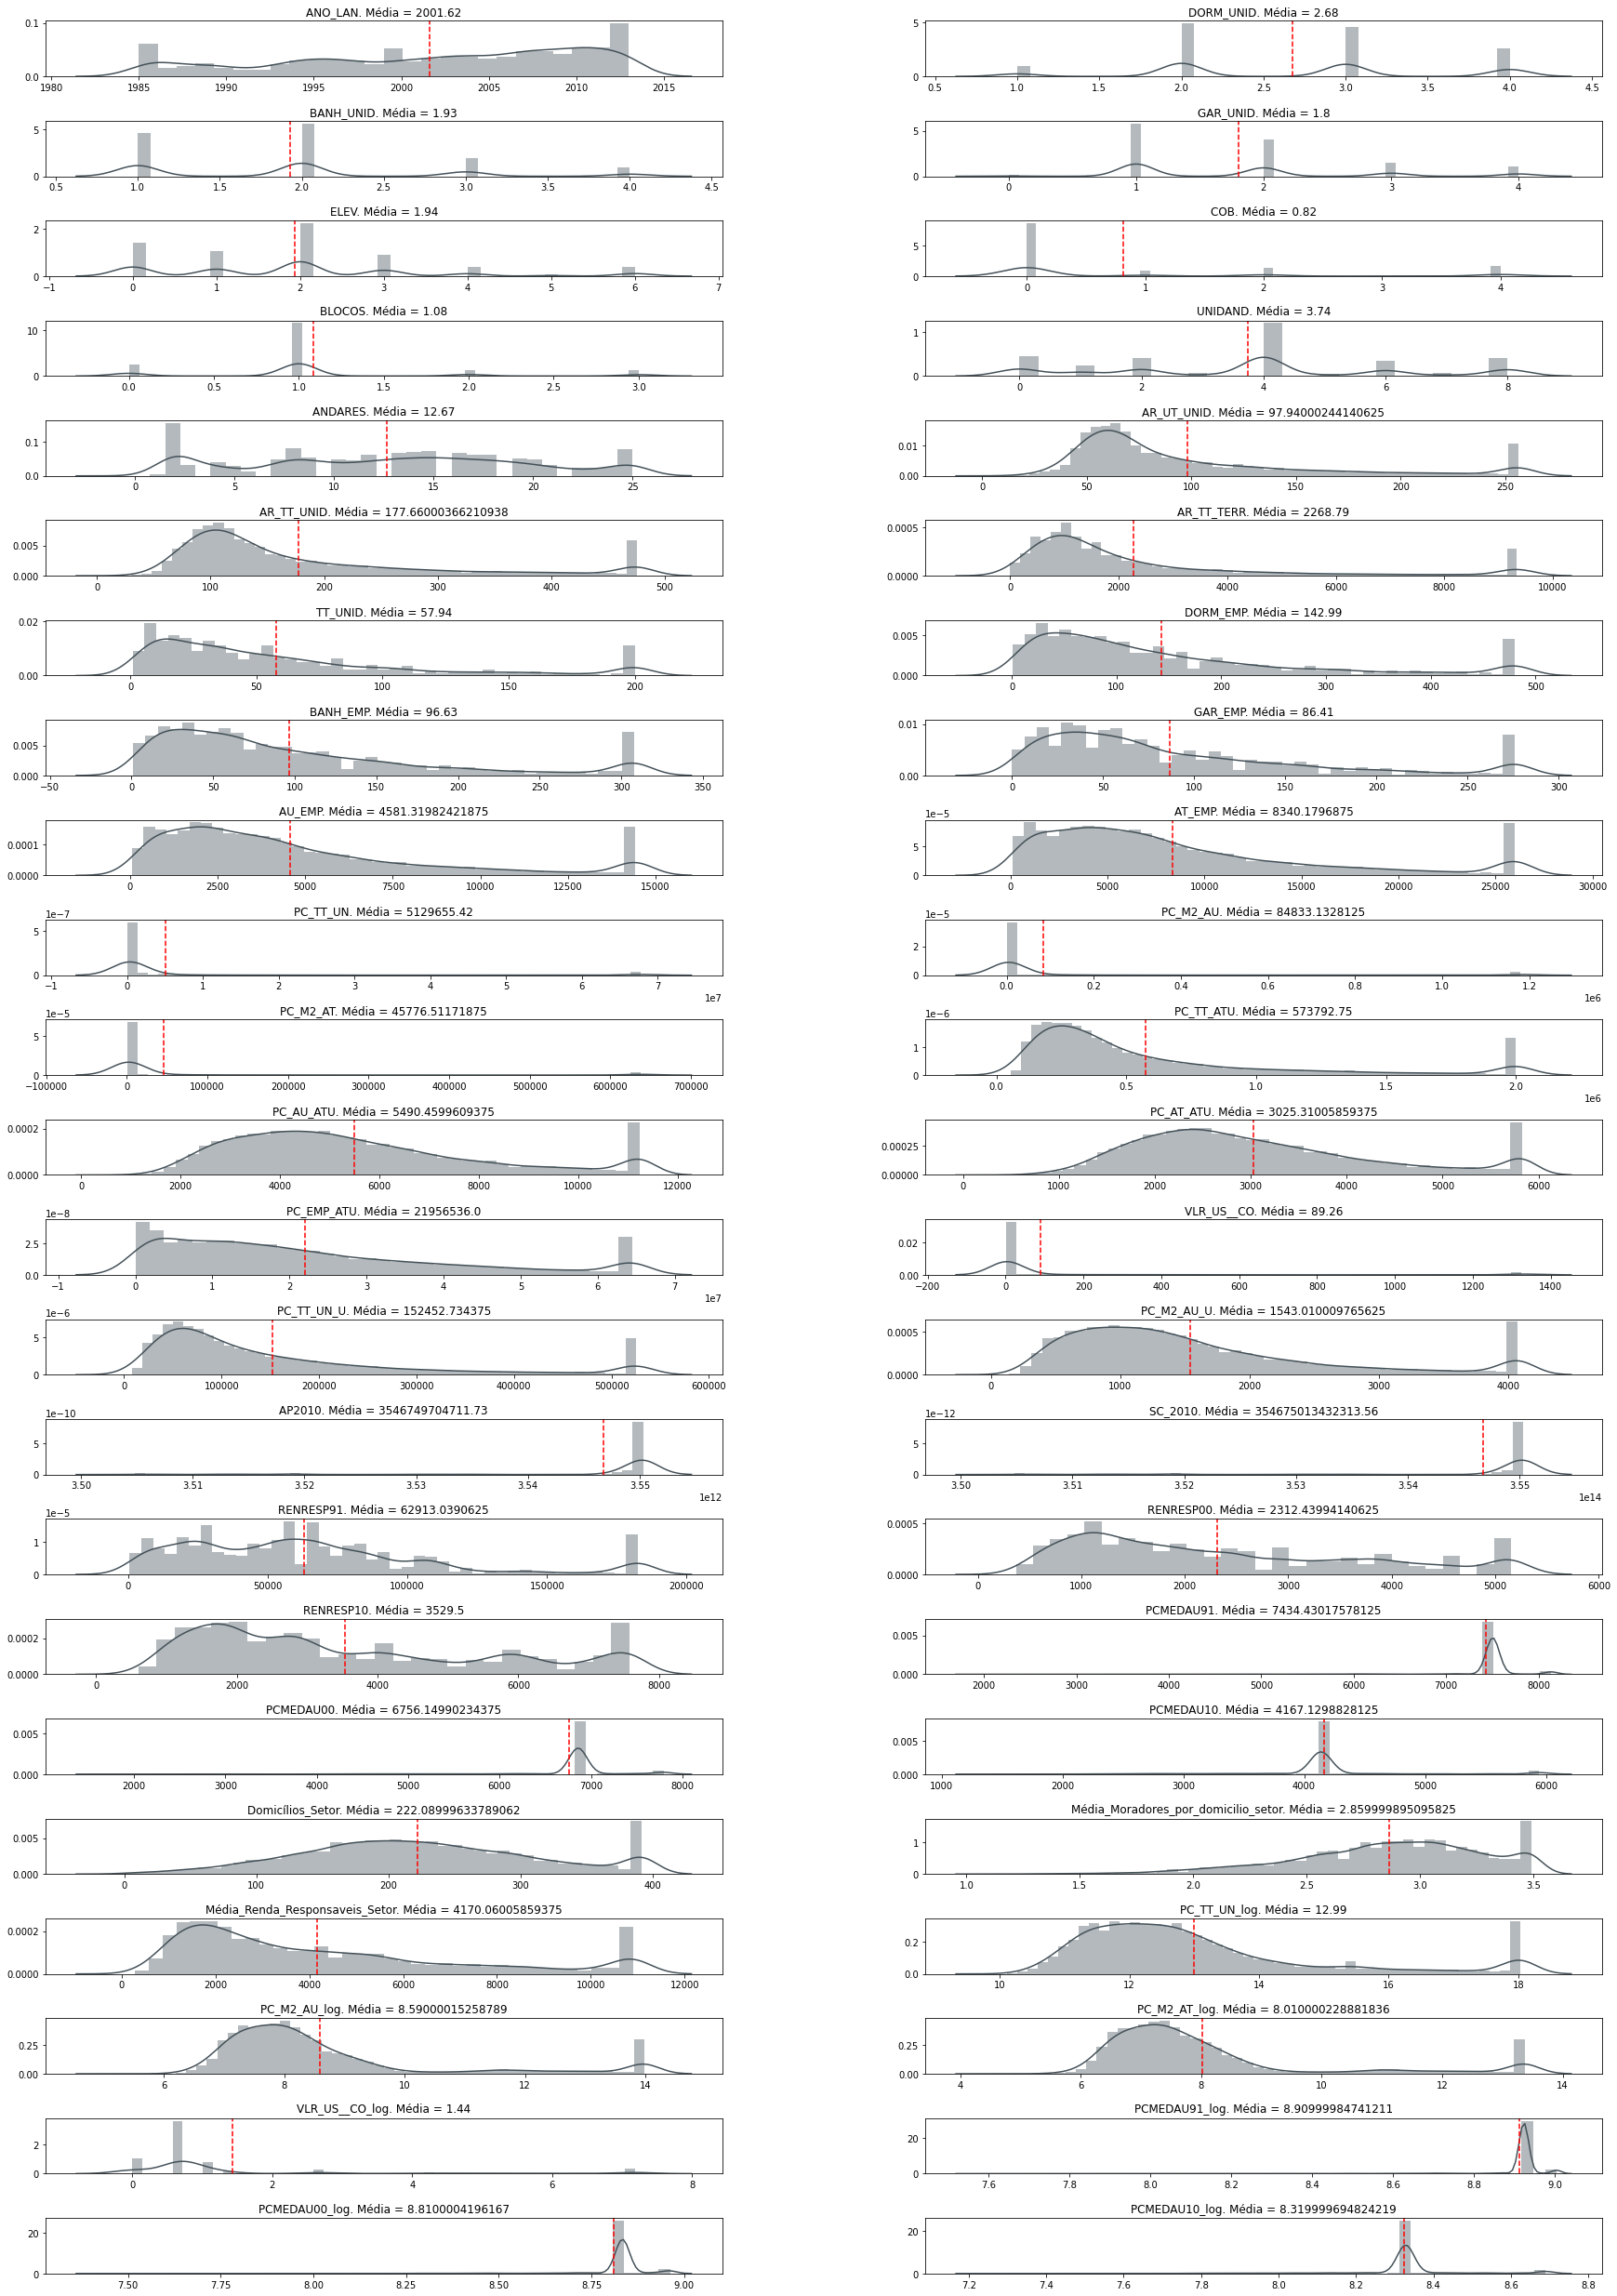

In [24]:
plot_hist_variaveis(v_numericos, df)